In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import io
import requests
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [2]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from sklearn.metrics import roc_auc_score
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn

In [3]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

#from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from torchmetrics.functional import auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [6]:
df = pd.read_csv('../rcsed.csv')

In [7]:
gasmet = pd.read_csv('../rcsed_gasmet.csv')

In [8]:
id_col = ['objid','specobjid']
z_col = [  'exp_tau','exp_met','z', 'e_bv', 'ssp_age', 'ssp_met', 'specclass']

band_col = [
    'corrmag_fuv', 'corrmag_nuv', 'corrmag_u', 'corrmag_g', 'corrmag_r', 'corrmag_i', 
    'corrmag_z', 'corrmag_y', 'corrmag_j', 'corrmag_h', 'corrmag_k'
]

kcorr_col = [
     'kcorr_fuv','kcorr_nuv','kcorr_u','kcorr_g','kcorr_r','kcorr_i',
     'kcorr_z','kcorr_y','kcorr_j','kcorr_h','kcorr_k',
]

In [9]:
col = id_col + z_col + band_col + kcorr_col

In [10]:
data = df[col].dropna()

In [37]:
data.shape

(90635, 31)

In [11]:
data[band_col].head()

,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k
18,20.430805,20.963827,19.483593,18.175556,17.582560,17.170374,16.867794,16.277828,16.224766,15.796741,15.897239
20,20.316390,19.689003,18.913360,17.633633,17.118832,16.801023,16.559082,16.183378,16.157516,16.061178,15.977037
25,20.786072,19.694458,18.216558,16.744936,15.942631,15.533159,15.280964,14.804124,14.598612,14.280346,14.365913
28,20.476007,19.936340,18.627714,17.455538,16.852865,16.501130,16.458048,15.947557,15.661368,15.418820,15.581812
29,19.992838,19.668417,18.950533,17.954803,17.538660,17.193727,17.054646,16.804903,16.682253,16.268763,16.288889


In [12]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [13]:
Encoder = torch.nn.Sequential(
    nn.Linear(11,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,256),
)
Mean = torch.nn.Sequential(
    nn.Linear(256,2),
)
Log_var = torch.nn.Sequential(
    nn.Linear(256,2),
)
Decoder = torch.nn.Sequential(
    nn.Linear(2,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,11),
    nn.Sigmoid()
)

class VAE(torch.nn.Module):
    def __init__(self, Encoder, Decoder, Mean, Log_var):
        super().__init__()
        self.encoder = Encoder
    
        self.mean = Mean 
        self.log_var = Log_var 
        
        self.decoder = Decoder
        
    def forward(self, x):
        x = self.encoder(x)
        
        #平均 μ
        mean = self.mean(x) 
       
        # log σ^2
        log_var = self.log_var(x)
        
        # 潜在変数を求める
        # 標準正規乱数を振る
        eps = torch.randn_like(torch.exp(log_var))
        
        # 潜在変数の計算 μ + σ・ε
        z = mean + torch.exp(log_var / 2) * eps
        
        x = self.decoder(z)
        return x, mean, log_var, z 

In [14]:
# 損失関数はなにがいい
def loss_function(maen, log_var):
    kl_loss = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return kl_loss 

In [15]:
x_train = np.array( data[band_col] )
mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
y_train = np.zeros([x_train.shape[0]])
# ミニバッチのサイズ指定
batch_size = 512

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [16]:
model = VAE(Encoder, Decoder, Mean, Log_var)
model.train()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
history = np.zeros((0,2))
criterion = nn.BCELoss()

In [30]:
num_epochs = 100
base_epochs = len(history)
for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0

    for i, (inputs, _) in enumerate(trainloader):
        outputs, mean, log_var, z = model(inputs.float())
        
        # 損失関数の計算
        loss = loss_function(mean, log_var)

        # パラメータの更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / i
    
    item = np.array([epoch+1, avg_train_loss])
    history = np.vstack((history, item))
    
    print('Epoch:',round((epoch+1)/( num_epochs+base_epochs),2),
          'loss:',avg_train_loss,
         )

Epoch: 0.34 loss: 0.0009054731851243703
Epoch: 0.35 loss: 0.0024968695505864203
Epoch: 0.35 loss: 0.001126294418916864
Epoch: 0.36 loss: 0.0008958802048095875
Epoch: 0.37 loss: 0.0021073678455783822
Epoch: 0.37 loss: 0.002955414481082205
Epoch: 0.38 loss: 0.0013579559528221518
Epoch: 0.39 loss: 0.0011249378239367642
Epoch: 0.39 loss: 0.0016717164866668357
Epoch: 0.4 loss: 0.0006706327368310616
Epoch: 0.41 loss: 0.0007758224751316221
Epoch: 0.41 loss: 0.00045594253108999824
Epoch: 0.42 loss: 0.0006906071961936304
Epoch: 0.43 loss: 0.0005661643157571049
Epoch: 0.43 loss: 0.0005619743112790383
Epoch: 0.44 loss: 0.0010226978420537743
Epoch: 0.45 loss: 0.0002409073255829892
Epoch: 0.45 loss: 0.00029144431911619367
Epoch: 0.46 loss: 0.00041085414293795655
Epoch: 0.47 loss: 0.0003418429086437333
Epoch: 0.47 loss: 0.0002243911142403123
Epoch: 0.48 loss: 0.0002299555614169708
Epoch: 0.49 loss: 0.0001686712106068929
Epoch: 0.49 loss: 0.00026604987807193046
Epoch: 0.5 loss: 0.00018374024137938764

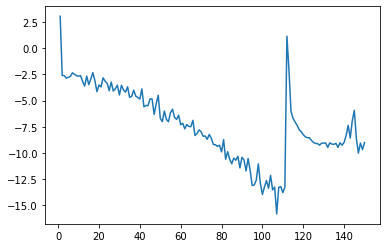

In [31]:
plt.plot(history[0:,0], np.log(history[0:,1]))

In [32]:
x = torch.from_numpy(x_train)
x = model.encoder(x.float())
mean = model.mean(x)
log_var = model.log_var(x)
latent = mean
eps = torch.randn(mean.shape)

# 潜在変数の計算 μ + σ・ε
z = mean + torch.exp(log_var/2) * eps

model.decoder(z)[:5]

tensor([[0.5013, 0.4773, 0.6196, 0.5336, 0.3846, 0.5313, 0.6156, 0.4489, 0.4643,
         0.4857, 0.5955],
        [0.5252, 0.4817, 0.6384, 0.5388, 0.3893, 0.5514, 0.6152, 0.4374, 0.4758,
         0.4871, 0.5789],
        [0.4521, 0.5334, 0.5910, 0.4850, 0.5054, 0.5848, 0.6393, 0.5491, 0.4928,
         0.4859, 0.5409],
        [0.4879, 0.4914, 0.6042, 0.6277, 0.4233, 0.5644, 0.5952, 0.4709, 0.4661,
         0.4871, 0.5508],
        [0.5115, 0.5105, 0.5559, 0.5420, 0.5297, 0.5048, 0.5403, 0.5492, 0.4202,
         0.4403, 0.4733]], grad_fn=<SliceBackward0>)

In [33]:
x_train[:5]

array([[0.51648396, 0.59232433, 0.37852666, 0.47868892, 0.46644511,
        0.46623528, 0.5082539 , 0.49309692, 0.46997571, 0.48640781,
        0.44300283],
       [0.50534071, 0.47840122, 0.34177825, 0.43714027, 0.43200528,
        0.43861369, 0.48263425, 0.4855253 , 0.46467827, 0.50704858,
        0.44895448],
       [0.5510846 , 0.4788887 , 0.29687316, 0.36900485, 0.34465202,
        0.34379762, 0.37656471, 0.37495686, 0.34187969, 0.36804454,
        0.32879055],
       [0.52088634, 0.50050419, 0.32336993, 0.42348593, 0.41225263,
        0.41618647, 0.47424956, 0.46662061, 0.42559551, 0.4569089 ,
        0.41947705],
       [0.47382891, 0.47656157, 0.34417385, 0.46176403, 0.46318477,
        0.46798171, 0.52376054, 0.53535009, 0.50601305, 0.52325177,
        0.47221362]])

In [34]:
latent1 = z[:,0]
latent2 = z[:,1]

In [35]:
latent1 = latent1.detach().numpy()
latent2 = latent2.detach().numpy()

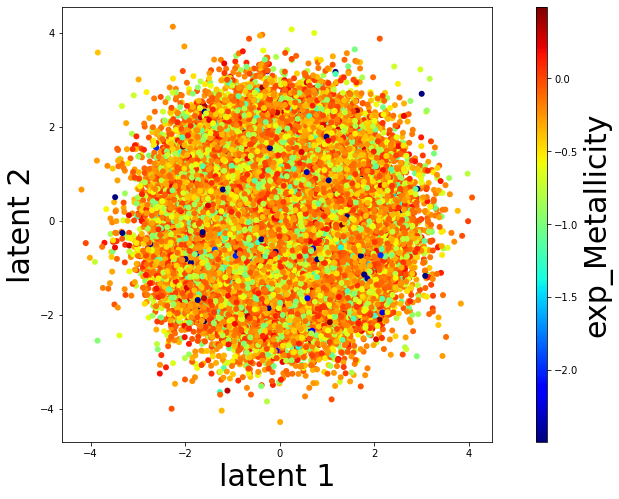

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'exp_Metallicity').set_label('exp_Metallicity', fontsize=30)
plt.savefig('encoder_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

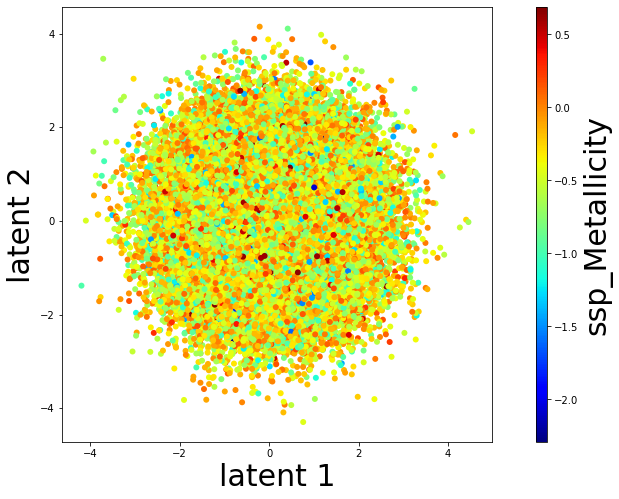

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'ssp_Metallicity').set_label('ssp_Metallicity', fontsize=30)
plt.savefig('encoder_ssp_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_tau'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('exp_tau[Myr]', fontsize=30)
plt.savefig('encoder_tau_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_age'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('ssp_age[Myr]', fontsize=30)
plt.savefig('encoder_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['z'].values, cmap=plt.cm.jet, edgecolor='none', vmax=0.2)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'z')
plt.savefig('encoder_z.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['e_bv'].values, cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'E(B-V)')
plt.savefig('E(B-V).png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

In [ ]:
data['specclass'].value_counts()